In [1]:
from radonpy.core import utils
from radonpy.sim import qm
from radonpy.ff.gaff2_mod import GAFF2_mod
%load_ext autoreload
%autoreload 2

In [2]:
ff = GAFF2_mod()
smiles = '*CC(*)c1ccccc1' 
mol = utils.mol_from_smiles(smiles)
work_dir = 'conformation_search_results'
omp_psi4 = 37
mpi = False
omp = 37
gpu = True
mol, energy = qm.conformation_search(mol, ff=ff, work_dir=work_dir, psi4omp=omp_psi4, mpi=mpi, omp=omp, gpu=gpu, log_name='monomer1')

RadonPy info: Start optimization of 2 conformers by MM level.
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy warning: GPU package is not available. Parallel number of GPU is changed to zero.
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy warning: GPU package is not available. Parallel number of GPU is changed to zero.
RadonPy info: Start optimization of 1 conformers by DFT level.
  Threads set to 37 by Python driver.

  Memory set to 953.674 MiB by Python driver.
RadonPy info: Psi4 optimization is running...


	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 9.00e-05

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 7.76e-06

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 6.36e-07

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.78e-08



Optimizer: Optimization complete!
RadonPy info: Normal termination of psi4 optimization. Elapsed time = 0:01:08.417474


In [3]:
from radonpy.sim import qm
import psi4
import os
tmp_dir = 'conformation_search_results/tmp'
mem_psi4 = 2048
psi4.set_num_threads(37)
qm.assign_charges(mol, charge='RESP', work_dir=work_dir, tmp_dir=tmp_dir, opt=False, omp=37, memory=mem_psi4) 
qm_data = qm.sp_prop(mol, opt=False, work_dir=work_dir, tmp_dir=tmp_dir, omp=omp_psi4, memory=mem_psi4) 
polar_data = qm.polarizability(mol, opt=False, work_dir=work_dir, tmp_dir=tmp_dir, omp=omp_psi4, memory=mem_psi4)

RadonPy info: Psi4 RESP charge calculation is running...
RadonPy info: Normal termination of psi4 RESP charge calculation. Elapsed time = 0:00:22.644895
RadonPy info: Psi4 single point calculation is running...
RadonPy info: Normal termination of psi4 single point calculation. Elapsed time = 0:00:13.124593
RadonPy info: Psi4 polarizability calculation (finite field) is running...
RadonPy info: Normal termination of psi4 polarizability calculation (finite field). Elapsed time = 0:02:32.717958


In [4]:
from radonpy.core import poly, utils
ter = utils.mol_from_smiles('*C')
qm.assign_charges(ter, charge='RESP', work_dir=work_dir, tmp_dir=tmp_dir, opt=False, omp=37, memory=mem_psi4)
n = poly.calc_n_from_num_atoms(mol, 100, terminal1=ter)
homopoly = poly.polymerize_rw(mol, n)
homopoly = poly.terminate_rw(homopoly, ter)

RadonPy info: Psi4 RESP charge calculation is running...
RadonPy info: Normal termination of psi4 RESP charge calculation. Elapsed time = 0:00:01.250731
RadonPy info: Start polymerize_rw.
RadonPy info: Start terminate_rw.


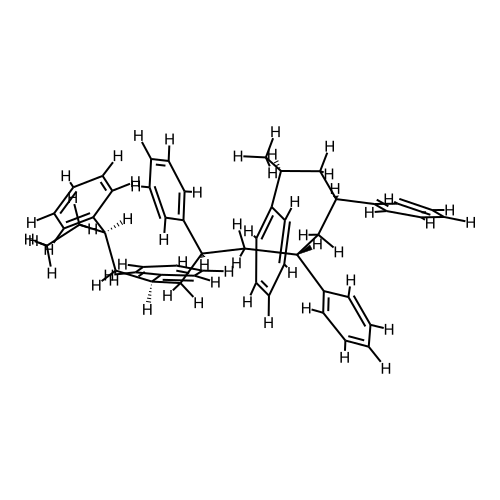

In [5]:
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
from io import BytesIO
width, height = 500, 500
drawer = rdMolDraw2D.MolDraw2DCairo(width, height)
drawer.DrawMolecule(
    homopoly,
)
drawer.FinishDrawing()
img_data = drawer.GetDrawingText()
Image.open(BytesIO(img_data))

In [6]:
from rdkit import Chem

# 假设 homopoly 是一个带有多个 conformer 的 RDKit Mol 对象
sdf_path = 'homopolymer.sdf'
writer = Chem.SDWriter(sdf_path)

# 如果只想保存主构象，直接写入即可
writer.write(homopoly)

# 如果想把所有 conformer 都写入（每个 conformer 作为一条记录），可以：
for conf_id in range(homopoly.GetNumConformers()):
    writer.write(homopoly, confId=conf_id)

writer.close()
print(f'SDF 文件已保存到: {sdf_path}')


SDF 文件已保存到: homopolymer.sdf


In [7]:
from radonpy.ff.gaff2 import GAFF2 
ff = GAFF2() 
result = ff.ff_assign(homopoly)

In [8]:
ac = poly.amorphous_cell(homopoly, 10, density=0.05)

RadonPy info: Start amorphous cell generation.


In [9]:
from radonpy.sim.preset import eq 
eqmd = eq.EQ21step(ac, work_dir=work_dir)
ac = eqmd.exec(temp=300, press=1.0, mpi=False, omp=37, gpu=True)


RadonPy info: Packing simulation (eq1) by LAMMPS is running...
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy warning: GPU package is not available. Parallel number of GPU is changed to zero.


KeyboardInterrupt: 